<a href="https://colab.research.google.com/github/Arkajeet7/boiling-heat-transfer-prediction/blob/main/boiling_H_T_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import  r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import cross_val_score
from sklearn.gaussian_process.kernels import Matern, RationalQuadratic
import seaborn as sns

In [2]:
# Step 1: Upload the file
from google.colab import files
uploaded = files.upload()


Saving Book2.csv to Book2.csv


In [3]:
data=pd.read_csv("Book2.csv")
data.head()

,angle,temp,voltage,s.r,h,q
0,57.65,18.65,0,0.19,50.43,940.5
1,69.84,14.00,2,0.42,82.50,1155.0
2,72.00,12.40,3,0.60,90.00,1250.0
3,80.00,10.70,4,0.75,150.00,1600.0
4,90.99,8.90,5,0.89,203.37,1810.0


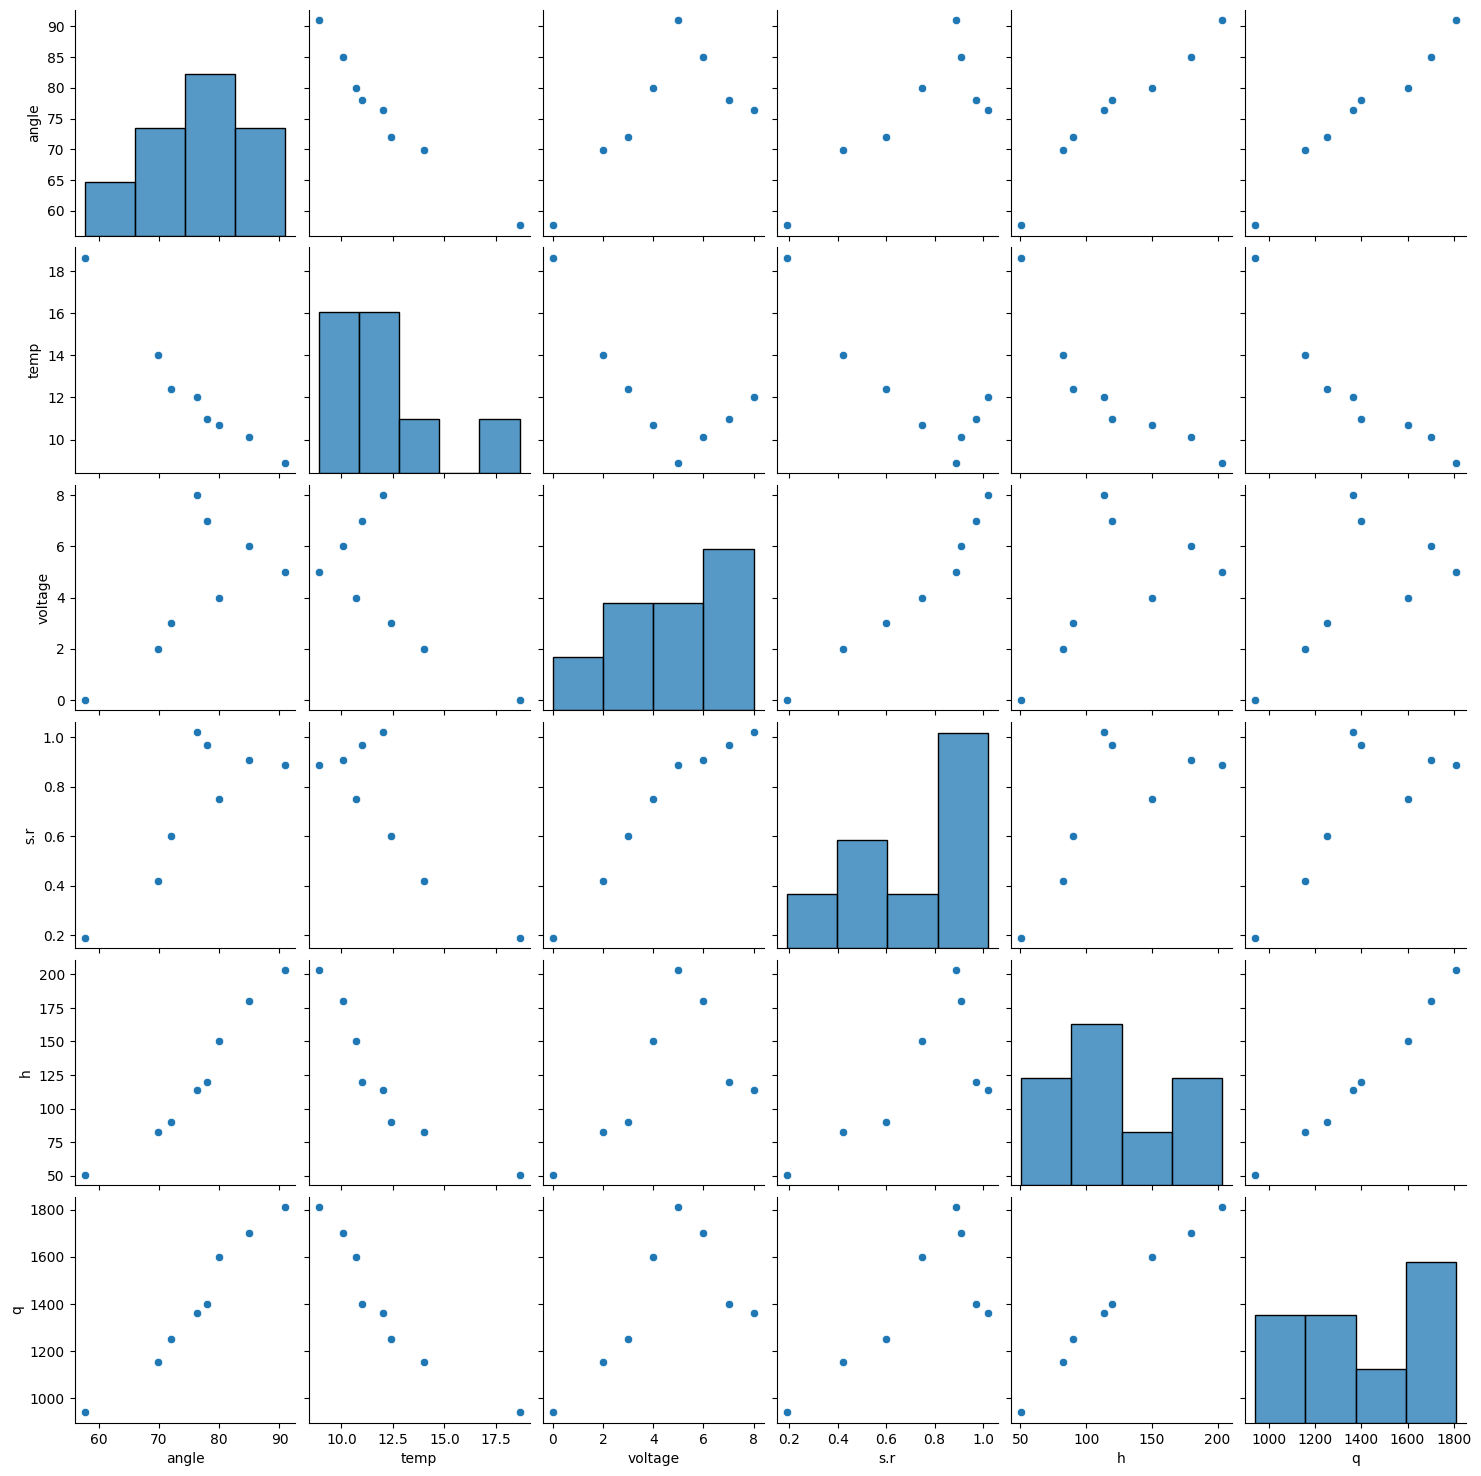

In [4]:
sns.pairplot(data)

In [5]:
scaler= StandardScaler()

scaled_data=scaler.fit_transform(data)

In [6]:
row_names=['angle','temp','voltage','roughness','htcoeff','heatflux']

scaled_dataframe=pd.DataFrame(scaled_data,columns=row_names)
scaled_dataframe.head()

,angle,temp,voltage,roughness,htcoeff,heatflux
0,-1.963349,2.275396,-1.752192,-1.924816,-1.523291,-1.696094
1,-0.674885,0.630212,-0.951190,-1.087544,-0.856871,-0.908302
2,-0.446576,0.064127,-0.550689,-0.432287,-0.701020,-0.559396
3,0.399012,-0.537338,-0.150188,0.113760,0.545792,0.726045
4,1.560638,-1.174184,0.250313,0.623404,1.654830,1.497309


#The following dataset has too little data in it, hence data has to be augmented. The methods of augmentation that are best fit are :


#1. Gaussian process regressor
#2. symbolic regressor



In [7]:
# using gaussian process regressor model of sklearn

y_scaled=scaled_dataframe.drop(['roughness','voltage'],axis=1)
x_scaled=scaled_dataframe.iloc[:,2:4]
y_scaled.head()

,angle,temp,htcoeff,heatflux
0,-1.963349,2.275396,-1.523291,-1.696094
1,-0.674885,0.630212,-0.856871,-0.908302
2,-0.446576,0.064127,-0.701020,-0.559396
3,0.399012,-0.537338,0.545792,0.726045
4,1.560638,-1.174184,1.654830,1.497309


In [8]:
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0)
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-10)
gpr.fit(x_scaled,y_scaled)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=10)

In [9]:
# Number of points to generate between min and max (inclusive)
n_points = 2000

# Generate linearly spaced values for each row
generated_data = x_scaled.T.apply(lambda row: np.linspace(row.min(), row.max(), n_points), axis=1)

# Convert the result to a new DataFrame
generated_df = pd.DataFrame(generated_data.tolist()).T
generated_df=generated_df.rename(columns={0:'voltage',1:'roughness'})
generated_df.head()

,voltage,roughness
0,-1.752192,-1.924816
1,-1.750589,-1.923305
2,-1.748986,-1.921793
3,-1.747383,-1.920282
4,-1.745780,-1.918770


In [10]:
y_pred=gpr.predict(generated_df)
y_pred=pd.DataFrame(y_pred)
y_pred=y_pred.rename(columns={0:'angle',1:'temp',2:'htcoeff',3:'heatflux'})
y_pred.head()

,angle,temp,htcoeff,heatflux
0,-1.963349,2.275396,-1.523291,-1.696094
1,-1.963567,2.275565,-1.523524,-1.696272
2,-1.963767,2.275711,-1.523742,-1.696435
3,-1.963948,2.275836,-1.523947,-1.696583
4,-1.964111,2.275938,-1.524139,-1.696716


In [11]:
augmented_data=pd.concat([generated_df,y_pred],axis=1)
augmented_data=augmented_data[['angle','temp','voltage','roughness','htcoeff','heatflux']]
augmented_data.head()

,angle,temp,voltage,roughness,htcoeff,heatflux
0,-1.963349,2.275396,-1.752192,-1.924816,-1.523291,-1.696094
1,-1.963567,2.275565,-1.750589,-1.923305,-1.523524,-1.696272
2,-1.963767,2.275711,-1.748986,-1.921793,-1.523742,-1.696435
3,-1.963948,2.275836,-1.747383,-1.920282,-1.523947,-1.696583
4,-1.964111,2.275938,-1.745780,-1.918770,-1.524139,-1.696716


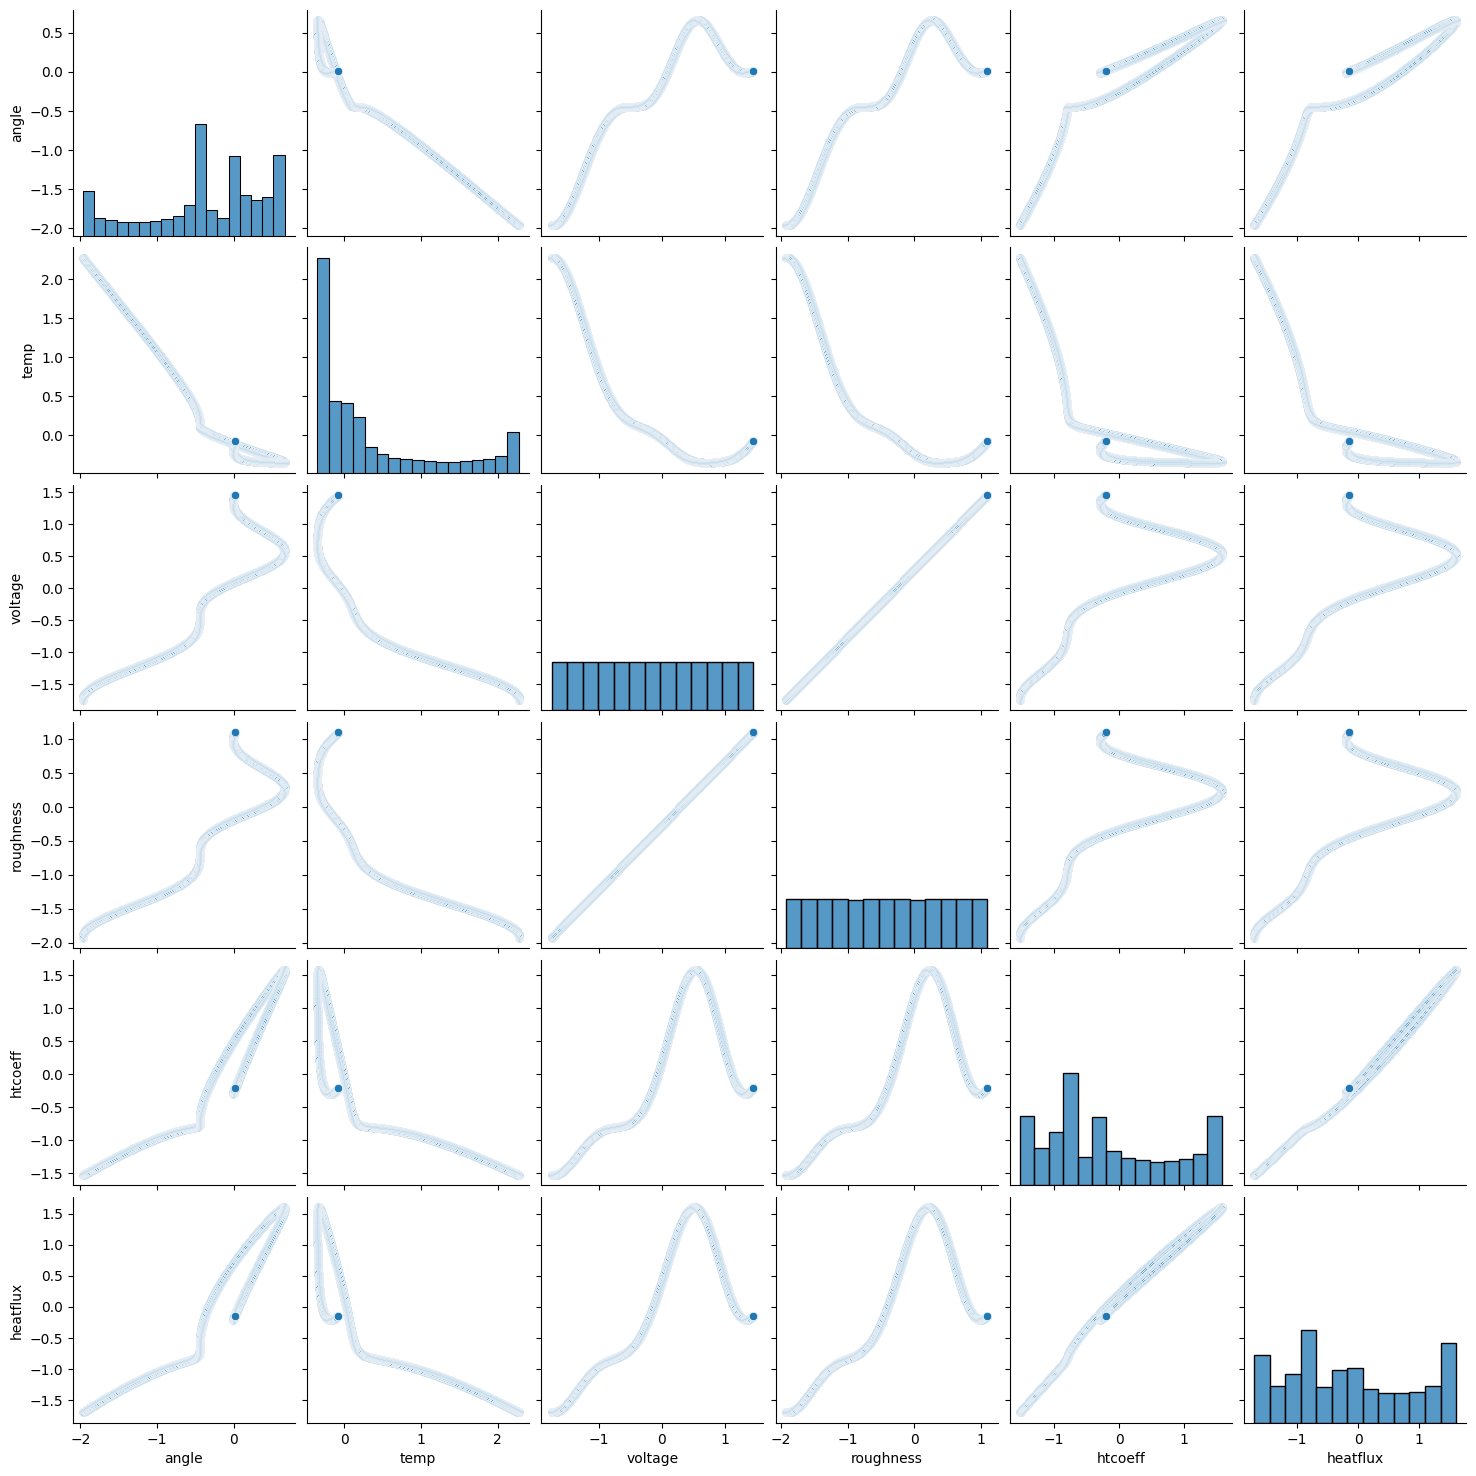

In [12]:
sns.pairplot(augmented_data)